In [1]:
from process_bigraph import ProcessTypes, Composite
from cdFBA import register_types, register_processes
from process_bigraph.emitter import gather_emitter_results
from cobra.io import load_model, read_sbml_model
from cobra.medium import minimal_medium
from vivaCRM.crm_gsmm_golford import (
    get_crm_goldford_emitter, 
    plot_crm_goldford_simulation)
from vivaCRM.crm_cdfba_utils import initial_environment, env_to_mcrm_state
from CRM.crm_gsmm_goldford_utils import ( 
    extract_yields, 
    extract_byproducts, 
    extract_uptake_rates, 
    run_mcrm_from_extractions, 
    plot_mcrm, 
    build_crm_goldford_config, 
    make_initial_state, 
    extract_yields_agora,
    extract_byproducts_agora,
    extract_uptake_rates_agora)
from vivaCRM.new_crm_gsmm_golford import build_params, MCRM_Process
from cdFBA.utils import get_objective_reaction

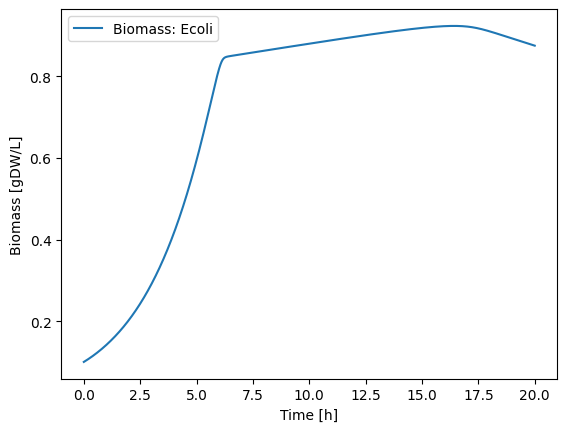

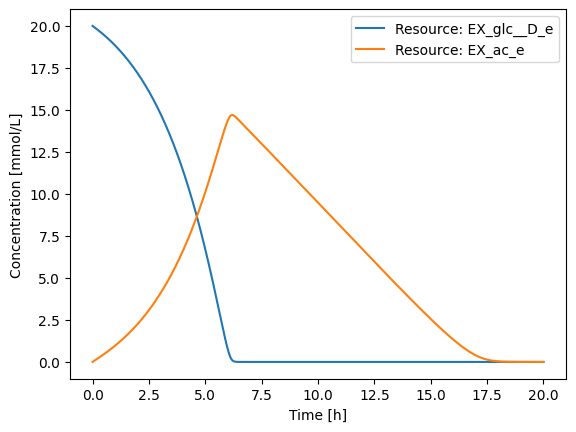

In [4]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model

#Extract information from the gsmm file
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 3) Initial conditions (dicts)
n0 = {"Ecoli": 0.1}
R0 = {"EX_glc__D_e": 20.0, "EX_ac_e": 0.0}

# 4) Simulate
t, X, sp_order, res_order, params = run_mcrm_from_extractions(
    extractions, resource_ids, Km,
    initial_biomass_by_species=n0,
    initial_resources_by_id=R0,
    use_uptake_as_vmax=True,
    dilution=0.0,
    T=20.0, steps=3000,
)

# 5) Plot
plot_mcrm(t, X, sp_order, res_order)

# Vivarium implementation

In [37]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 2) build crm_goldford config
cfg = build_crm_goldford_config(extractions, resource_ids, Km,
                                maintenance_by_species={"Ecoli": 0.00},
                                dilution=0.0,
                                feed_by_resource={}, resource_loss_by_resource={})

# 3) initial state
state0 = make_initial_state(["Ecoli"], resource_ids,
                            n0_by_species={"Ecoli": 0.1},
                            R0_by_resource={"EX_glc__D_e":20.0, "EX_ac_e": 0.0})

In [38]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [39]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}


spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [40]:
spec

{'adaptive_crm': {'_type': 'process',
  'address': 'local:MCRM_Process',
  'config': {'species_names': ['Ecoli'],
   'resource_names': ['EX_glc__D_e', 'EX_ac_e'],
   'params': MCRMParams(yields=array([[0.03646071, 0.01857921]]), vmax=array([[10.       ,  1.6836817]]), B=array([[[0.       , 0.       ],
           [0.9096579, 0.       ]]]), Km=array([0.5, 0.5]), maintenance=array([0.]), dilution=0.0, feed=None, resource_loss=array([0., 0.])),
   'method': 'RK45',
   'rtol': 1e-05,
   'atol': 1e-07,
   'max_step': 0.05,
   'clip_nonnegative': True},
  'inputs': {'species': ['species'], 'concentrations': ['concentrations']},
  'outputs': {'species_delta': ['species'],
   'concentrations_delta': ['concentrations']},
  'interval': 0.5},
 'species': {'Ecoli': 0.1},
 'concentrations': {'EX_glc__D_e': 20.0, 'EX_ac_e': 0.0},
 'strategies': {'Ecoli': {'EX_glc__D_e': 0.0, 'EX_ac_e': 0.0}},
 'emitter': {'_type': 'step',
  'address': 'local:ram-emitter',
  'config': {'emit': {'concentrations': 'any'

In [41]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [42]:
params

MCRMParams(yields=array([[0.03646071, 0.01857921]]), vmax=array([[10.       ,  1.6836817]]), B=array([[[0.       , 0.       ],
        [0.9096579, 0.       ]]]), Km=array([0.5, 0.5]), maintenance=array([0.]), dilution=0.0, feed=None, resource_loss=array([0., 0.]))

In [43]:
sim.run(20)

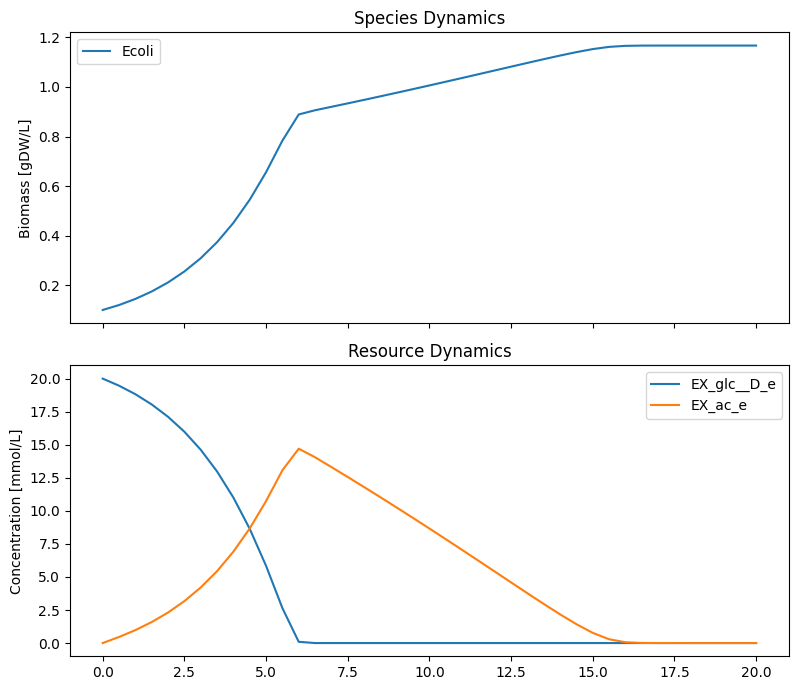

In [44]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)

In [11]:
results

[{'species': {'Ecoli': 0.1},
  'global_time': 0.0,
  'concentrations': {'EX_glc__D_e': 20.0, 'EX_ac_e': 0.0}},
 {'species': {'Ecoli': 0.11999647067587339},
  'global_time': 0.5,
  'concentrations': {'EX_glc__D_e': 19.465396118131217,
   'EX_ac_e': 0.459153242981178}},
 {'species': {'Ecoli': 0.14463571351362367},
  'global_time': 1.0,
  'concentrations': {'EX_glc__D_e': 18.82266677055849,
   'EX_ac_e': 0.9789628149796163}},
 {'species': {'Ecoli': 0.1746704147600737},
  'global_time': 1.5,
  'concentrations': {'EX_glc__D_e': 18.04786675554844,
   'EX_ac_e': 1.5876894207618744}},
 {'species': {'Ecoli': 0.21115132326097844},
  'global_time': 2.0,
  'concentrations': {'EX_glc__D_e': 17.11284855291254,
   'EX_ac_e': 2.3096204362937924}},
 {'species': {'Ecoli': 0.2553763400184737},
  'global_time': 2.5,
  'concentrations': {'EX_glc__D_e': 15.984175337570333,
   'EX_ac_e': 3.170932023693851}},
 {'species': {'Ecoli': 0.3089049753393541},
  'global_time': 3.0,
  'concentrations': {'EX_glc__D_e':

## To Do -  Implement this with multiple species and volumetric environment

In [12]:
gut_normal = {
    'E_rectale': ('/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml'),
    'B_thetaiotaomicron' : ('/Users/edwin/Downloads/reconstructions/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml'),
    'Methanobrevibacter_smithii': ('/Users/edwin/Downloads/reconstructions/sbml/Methanobrevibacter_smithii_ATCC_35061.xml')
}

In [13]:
def get_mini_medium(model, target_growth = 10e-4):
    
				## make a copy of the model
    try_model = model.copy()
    
				## compute the minimum media neccessary for growth at targeted_growth
    mini_growth = minimal_medium(try_model,target_growth, minimize_components=10,open_exchanges=True)
    
				## set minimal medium
    mini_medium = {}
    for i in mini_growth.index:
            mini_medium[i] = try_model.medium[i]
            
				## get all other metabolites that can be added to the medium
    additional_medium = try_model.medium
    for i in mini_medium.keys():
            del additional_medium[i]
    return mini_medium, additional_medium

In [14]:
gut_models = {
    "B_thetaiotaomicron": "/Users/edwin/Downloads/reconstructions/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml",
    "E_rectale": "/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml",
    "Methanobrevibacter_smithii": "/Users/edwin/Downloads/reconstructions/sbml/Methanobrevibacter_smithii_ATCC_35061.xml",
}
models = {k: read_sbml_model(v) for k, v in gut_models.items()}

In [15]:
models

{'B_thetaiotaomicron': <Model Bacteroides_thetaiotaomicron_VPI_5482 at 0x133542090>,
 'E_rectale': <Model Eubacterium_rectale_ATCC_33656 at 0x1651bc450>,
 'Methanobrevibacter_smithii': <Model Methanobrevibacter_smithii_ATCC_35061 at 0x134da9350>}

In [16]:
BT = models["B_thetaiotaomicron"]
ER = models["E_rectale"]
MS = models["Methanobrevibacter_smithii"]

In [17]:
BT_mini_medium = get_mini_medium(BT)[0]
ER_mini_medium = get_mini_medium(ER)[0]
ER_mini_medium["EX_ac(e)"] = 1000

In [18]:
BT.medium = BT_mini_medium
ER.medium = ER_mini_medium

In [19]:
# --- 0) Load models and set biomass IDs ---
from cobra.io import read_sbml_model

models = {
    "B_thetaiotaomicron": BT,
    "E_rectale": ER,
}
biomass_id = {
    "B_thetaiotaomicron": "EX_biomass(e)",   # set to the exact biomass rxn id in your model
    "E_rectale": "EX_biomass(e)",
}

# --- 1) Exchanges to track (use YOUR IDs exactly) ---
resource_ids = ["EX_hspg(e)", "EX_ac(e)", "EX_but(e)"]

# --- 2) Extract yields, uptakes, byproducts for each species under a unified medium ---
extractions = {
    "B_thetaiotaomicron": {
        "yields":     extract_yields_agora(models["B_thetaiotaomicron"], resource_ids,
                                           biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["B_thetaiotaomicron"], resource_ids,
                                               biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["B_thetaiotaomicron"], resource_ids,
                                                 biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                                 use_pfba=False),
    },
    "E_rectale": {
        "yields":     extract_yields_agora(models["E_rectale"], resource_ids,
                                           biomass_rxn_id=biomass_id["E_rectale"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["E_rectale"], resource_ids,
                                               biomass_rxn_id=biomass_id["E_rectale"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["E_rectale"], resource_ids,
                                                 biomass_rxn_id=biomass_id["E_rectale"],
                                                 use_pfba=False),
    }
}

# --- 3) Monod Km per resource (tune later) ---
Km = {"EX_hspg(e)": 0.5, "EX_ac(e)": 0.5, "EX_but(e)": 0.5}

# --- 4) Build CRM config (Goldford-style) ---
cfg = build_crm_goldford_config(
    extractions,
    resource_ids,
    Km,
    maintenance_by_species={"B_thetaiotaomicron": 0.2, "E_rectale": 0.2},
    dilution=0.0,
    feed_by_resource={},              # e.g., set EX_hspg(e) here if you run as chemostat (dilution>0)
    resource_loss_by_resource={},     # optional abiotic loss rates per resource
)

# --- 5) Initial state: HSPG present; acetate/butyrate start at 0 ---
state0 = make_initial_state(
    ["B_thetaiotaomicron", "E_rectale"],
    resource_ids,
    n0_by_species={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    R0_by_resource={"EX_hspg(e)": 20.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0}
)

35.26104481806471
35.26104481806459
29.053714691291876
29.0537150078768


In [20]:
extractions

{'B_thetaiotaomicron': {'yields': {'EX_hspg(e)': 0.6812945249919047,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'byproducts': {'EX_hspg(e)': {'EX_ac(e)': 924.7005322065392,
    'EX_agam1b3agal(e)': 126.3095365782736,
    'EX_co2(e)': 910.9643907219178,
    'EX_for(e)': 7.786026567321757,
    'EX_h(e)': 258.3922010937106,
    'EX_h2s(e)': 354.44518032321474,
    'EX_hspg_degr_2(e)': 51.75594918876492,
    'EX_idour(e)': 51.75594918876494,
    'EX_nh4(e)': 180.7328017317327,
    'EX_ppi(e)': 166.1733387458632},
   'EX_ac(e)': {'EX_ac(e)': 924.7005322065392,
    'EX_agam1b3agal(e)': 126.3095365782736,
    'EX_co2(e)': 910.9643907219178,
    'EX_for(e)': 7.786026567321757,
    'EX_h(e)': 258.3922010937106,
    'EX_h2s(e)': 354.44518032321474,
    'EX_hspg_degr_2(e)': 51.75594918876492,
    'EX_idour(e)': 51.75594918876494,
    'EX_nh4(e)': 180.7328017317327,
    'EX_ppi(e)': 166.1733387458632},
   'EX_but(e)': {}},
  'uptakes': {'EX_hspg(e)': 51.75594918876493,
   'EX_ac(e)': 0.0,
   'EX_

In [21]:
cfg

{'species_names': ['B_thetaiotaomicron', 'E_rectale'],
 'resource_names': ['EX_hspg(e)', 'EX_ac(e)', 'EX_but(e)'],
 'yields': {'B_thetaiotaomicron': {'EX_hspg(e)': 0.6812945249919047,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.1039728002083,
   'EX_but(e)': 0.0}},
 'resource_uptakes': {'B_thetaiotaomicron': {'EX_hspg(e)': 51.75594918876493,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 279.43571877014085,
   'EX_but(e)': 0.0}},
 'maintenance': {'B_thetaiotaomicron': 0.2, 'E_rectale': 0.2},
 'Km': {'EX_hspg(e)': 0.5, 'EX_ac(e)': 0.5, 'EX_but(e)': 0.5},
 'byproducts': {'B_thetaiotaomicron': {'EX_hspg(e)': {'EX_ac(e)': 17.866555375768687}},
  'E_rectale': {'EX_ac(e)': {'EX_but(e)': 2.2192349637183137}}},
 'dilution': 0.0,
 'feed': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0},
 'resource_loss': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}}

In [22]:
#cfg["resource_uptakes"]["B_thetaiotaomicron"]["EX_hspg(e)"] = 5
#cfg["resource_uptakes"]["E_rectale"]["EX_ac(e)"] = 2

In [23]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [24]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

In [25]:
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [26]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [27]:
sim.run(10)

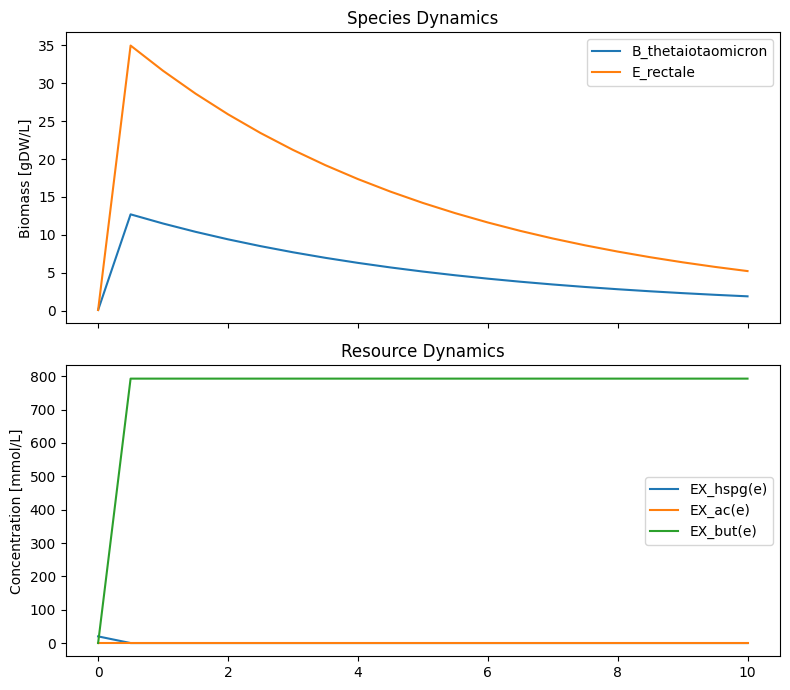

In [28]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)

In [29]:
results

[{'species': {'B_thetaiotaomicron': 0.1, 'E_rectale': 0.1},
  'global_time': 0.0,
  'concentrations': {'EX_hspg(e)': 20.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}},
 {'species': {'B_thetaiotaomicron': 12.709898506422352,
   'E_rectale': 34.964429292801476},
  'global_time': 0.5,
  'concentrations': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 793.0016882973531}},
 {'species': {'B_thetaiotaomicron': 11.500391748050331,
   'E_rectale': 31.637123924399447},
  'global_time': 1.0,
  'concentrations': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 793.0016882973531}},
 {'species': {'B_thetaiotaomicron': 10.405984775707948,
   'E_rectale': 28.626453525837363},
  'global_time': 1.5,
  'concentrations': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 793.0016882973531}},
 {'species': {'B_thetaiotaomicron': 9.415724396573113,
   'E_rectale': 25.90228629584514},
  'global_time': 2.0,
  'concentrations': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 793.00168829735

In [30]:
cfg["resource_uptakes"]["B_thetaiotaomicron"]["EX_hspg(e)"] = 2

In [31]:
cfg["resource_uptakes"]["E_rectale"]["EX_ac(e)"] = 0.5

In [32]:
cfg

{'species_names': ['B_thetaiotaomicron', 'E_rectale'],
 'resource_names': ['EX_hspg(e)', 'EX_ac(e)', 'EX_but(e)'],
 'yields': {'B_thetaiotaomicron': {'EX_hspg(e)': 0.6812945249919047,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.1039728002083,
   'EX_but(e)': 0.0}},
 'resource_uptakes': {'B_thetaiotaomicron': {'EX_hspg(e)': 2,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.5, 'EX_but(e)': 0.0}},
 'maintenance': {'B_thetaiotaomicron': 0.2, 'E_rectale': 0.2},
 'Km': {'EX_hspg(e)': 0.5, 'EX_ac(e)': 0.5, 'EX_but(e)': 0.5},
 'byproducts': {'B_thetaiotaomicron': {'EX_hspg(e)': {'EX_ac(e)': 17.866555375768687}},
  'E_rectale': {'EX_ac(e)': {'EX_but(e)': 2.2192349637183137}}},
 'dilution': 0.0,
 'feed': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0},
 'resource_loss': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}}

In [33]:

species_names  = ["B_thetaiotaomicron", "E_rectale"]
resource_names = ["EX_hspg(e)", "EX_ac(e)", "EX_but(e)"]  

# ------------------------
yields_map = {
    "B_thetaiotaomicron": {"EX_hspg(e)": 0.04, "EX_ac(e)": 0.0, "EX_but(e)": 0.0},  # gDW/mmol
    "E_rectale":          {"EX_hspg(e)": 0.0,  "EX_ac(e)": 0.03, "EX_but(e)": 0.0},
}
vmax_map = {
    "B_thetaiotaomicron": {"EX_hspg(e)": 8.0,  "EX_ac(e)": 0.0,  "EX_but(e)": 0.0},  # mmol/(gDW·h)
    "E_rectale":          {"EX_hspg(e)": 0.0,  "EX_ac(e)": 6.0,  "EX_but(e)": 0.0},
}
# Produced_per_consumed (dimensionless): B[species, produced_i, consumed_j]
byproducts_map = {
    "B_thetaiotaomicron": {
        "EX_hspg(e)": {"EX_ac(e)": 1.0},      # HSPG → acetate
    },
    "E_rectale": {
        "EX_ac(e)":   {"EX_but(e)": 0.7},     # acetate → butyrate
    },
}
Km_map = {"EX_hspg(e)": 0.5, "EX_ac(e)": 0.3, "EX_but(e)": 0.2}   # mmol/L
maintenance_map = {"B_thetaiotaomicron": 0.02, "E_rectale": 0.02}

# ------------------------
# 2) Build MCRM params
# ------------------------
params = build_params(
    species_names=species_names,
    resource_names=resource_names,
    yields_map=yields_map,
    vmax_map=vmax_map,
    maintenance_map=maintenance_map,
    Km_map=Km_map,
    byproducts_map=byproducts_map,   # encodes BT→Acetate and ER→Butyrate
    dilution=0.0,                    # batch; set >0 with feed_map for chemostat
)

# ------------------------
# 3) Use your cdFBA environment helper to set starting conditions
#    (Pass exchange IDs directly as `substrates` to keep labels consistent.)
# ------------------------
env = initial_environment(
    volume=1.0,
    species_list=species_names,
    substrates=resource_names,
    # overrides are optional; here we pin substrates and species starts:
    resource_overrides={"EX_hspg(e)": 20.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0},
    biomass_overrides={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    default_resource=0.0,   # anything not listed starts at 0
)

state0 = env_to_mcrm_state(env, species_names, resource_names)


In [34]:
state0

{'species': {'B_thetaiotaomicron': 0.1, 'E_rectale': 0.1},
 'concentrations': {'EX_hspg(e)': 20.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}}

In [35]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

In [36]:
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [37]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [38]:
sim.run(20)

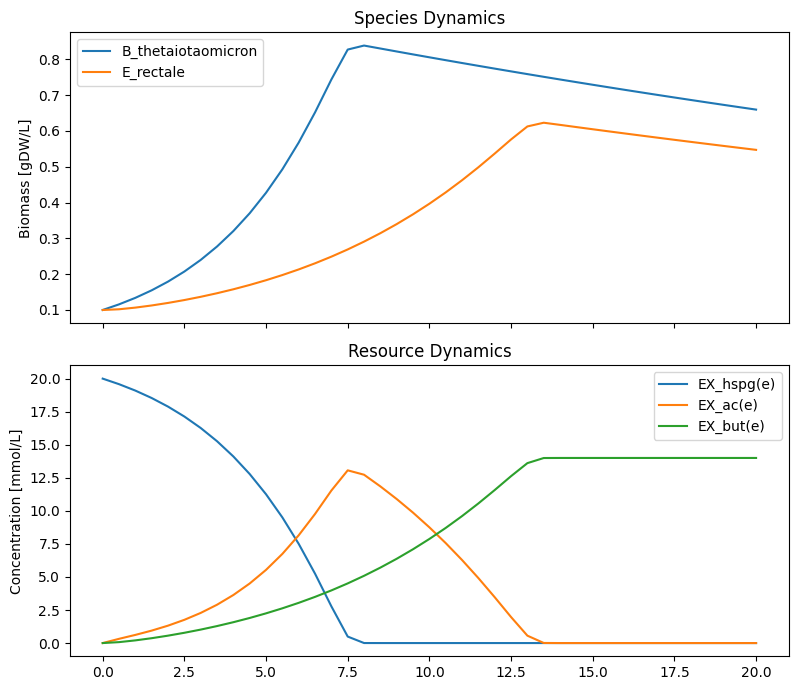

In [39]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)

In [40]:
results

[{'species': {'B_thetaiotaomicron': 0.1, 'E_rectale': 0.1},
  'global_time': 0.0,
  'concentrations': {'EX_hspg(e)': 20.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}},
 {'species': {'B_thetaiotaomicron': 0.11572633215793841,
   'E_rectale': 0.10199589549712927},
  'global_time': 0.5,
  'concentrations': {'EX_hspg(e)': 19.579923557769742,
   'EX_ac(e)': 0.3200010247327783,
   'EX_but(e)': 0.07005279224823244}},
 {'species': {'B_thetaiotaomicron': 0.1339138021559575,
   'E_rectale': 0.1066227392271375},
  'global_time': 1.0,
  'concentrations': {'EX_hspg(e)': 19.094086823279838,
   'EX_ac(e)': 0.6168857279500688,
   'EX_but(e)': 0.20231921413906187}},
 {'species': {'B_thetaiotaomicron': 0.15494268054176388,
   'E_rectale': 0.11261957400978467},
  'global_time': 1.5,
  'concentrations': {'EX_hspg(e)': 18.532321319969814,
   'EX_ac(e)': 0.9422487758425656,
   'EX_but(e)': 0.3678009329313292}},
 {'species': {'B_thetaiotaomicron': 0.17924978436043215,
   'E_rectale': 0.1196961048387843},
  'global_t

In [41]:
{'concentrations': {'EX_hspg(e)': 20.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0, 'B_thetaiotaomicron': 0.1, 'E_rectale': 0.1}}

{'concentrations': {'EX_hspg(e)': 20.0,
  'EX_ac(e)': 0.0,
  'EX_but(e)': 0.0,
  'B_thetaiotaomicron': 0.1,
  'E_rectale': 0.1}}

In [42]:
env

{'volume': 1.0,
 'counts': {'EX_hspg(e)': 20.0,
  'EX_ac(e)': 0.0,
  'EX_but(e)': 0.0,
  'B_thetaiotaomicron': 0.1,
  'E_rectale': 0.1},
 'concentrations': {'EX_hspg(e)': 20.0,
  'EX_ac(e)': 0.0,
  'EX_but(e)': 0.0,
  'B_thetaiotaomicron': 0.1,
  'E_rectale': 0.1}}

In [45]:
# --- Species & resources (add MS + gases) ---
species_names  = ["B_thetaiotaomicron", "E_rectale", "Methanobrevibacter_smithii"]
resource_names = ["EX_hspg(e)", "EX_ac(e)", "EX_but(e)", "EX_h2(e)", "EX_co2(e)", "EX_ch4(e)"]

# --- Yields Y_X/S (gDW per mmol substrate) ---
yields_map = {
    "B_thetaiotaomicron": {
        "EX_hspg(e)": 0.04, "EX_ac(e)": 0.0, "EX_but(e)": 0.0, "EX_h2(e)": 0.0, "EX_co2(e)": 0.0, "EX_ch4(e)": 0.0
    },
    "E_rectale": {
        "EX_hspg(e)": 0.0,  "EX_ac(e)": 0.03, "EX_but(e)": 0.0, "EX_h2(e)": 0.0, "EX_co2(e)": 0.0, "EX_ch4(e)": 0.0
    },
    "Methanobrevibacter_smithii": {
        # MS grows on H2 + CO2; yield here is tied to H2 (tune with extractor)
        "EX_hspg(e)": 0.0,  "EX_ac(e)": 0.0,  "EX_but(e)": 0.0,
        "EX_h2(e)": 0.01,   "EX_co2(e)": 0.2, "EX_ch4(e)": 0.0
    },
}

# --- Vmax (mmol/(gDW·h)) per resource (actual uptake you want MS/ER/BT to have) ---
vmax_map = {
    "B_thetaiotaomicron": {"EX_hspg(e)": 8.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0, "EX_h2(e)": 0.0, "EX_co2(e)": 0.0, "EX_ch4(e)": 0.0},
    "E_rectale":          {"EX_hspg(e)": 0.0, "EX_ac(e)": 6.0, "EX_but(e)": 0.0, "EX_h2(e)": 0.0, "EX_co2(e)": 0.0, "EX_ch4(e)": 0.0},
    "Methanobrevibacter_smithii": {
        # MS consumes H2 (primary driver); set CO2 uptake via feed/initial pool
        "EX_hspg(e)": 0.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0,
        "EX_h2(e)": 10.0,   "EX_co2(e)": 0.0, "EX_ch4(e)": 0.0
    },
}

# --- Byproducts map (mmol product per mmol substrate consumed) ---
# B[species][consumed_resource][produced_resource] = stoich
byproducts_map = {
    "B_thetaiotaomicron": {
        "EX_hspg(e)": {"EX_ac(e)": 1.0,
                       # (optional) seed some H2 production if you want to feed MS from BT:
                       # "EX_h2(e)": 0.2
        },
    },
    "E_rectale": {
        "EX_ac(e)": {"EX_but(e)": 0.7},
    },
    "Methanobrevibacter_smithii": {
        # 4 H2 + CO2 -> CH4 + 2 H2O
        # Tie CH4 production to H2 consumption: 0.25 mol CH4 / mol H2
        "EX_h2(e)": {"EX_ch4(e)": 0.25},
        # If you want to enforce CO2 coupling explicitly, you could also add:
        # "EX_co2(e)": {"EX_ch4(e)": 1.0}
        # but that would double-count unless you also model the H2:CO2 coupling—so usually keep CH4 linked to H2 only.
    },
}

# --- Monod K (mmol/L) per resource (shared for all species; tweak as needed) ---
Km_map = {
    "EX_hspg(e)": 0.5, "EX_ac(e)": 0.3, "EX_but(e)": 0.2,
    "EX_h2(e)": 0.05,  "EX_co2(e)": 0.05, "EX_ch4(e)": 0.05
}

# --- Maintenance (1/h) ---
maintenance_map = {"B_thetaiotaomicron": 0.02, "E_rectale": 0.02, "Methanobrevibacter_smithii": 0.02}

In [58]:
# ------------------------
# 2) Build MCRM params
# ------------------------
params = build_params(
    species_names=species_names,
    resource_names=resource_names,
    yields_map=yields_map,
    vmax_map=vmax_map,
    maintenance_map=maintenance_map,
    Km_map=Km_map,
    byproducts_map=byproducts_map,  # encodes BT→Acetate and ER→Butyrate
    dilution=0.0,  # batch; set >0 with feed_map for chemostat
)

# ------------------------
# 3) Use your cdFBA environment helper to set starting conditions
#    (Pass exchange IDs directly as `substrates` to keep labels consistent.)
# ------------------------
env = initial_environment(
    volume=1.0,
    species_list=species_names,
    substrates=resource_names,
    # overrides are optional; here we pin substrates and species starts:
    resource_overrides={"EX_hspg(e)": 20.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0},
    biomass_overrides={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    default_resource=0.0,  # anything not listed starts at 0
)

state0 = env_to_mcrm_state(env, species_names, resource_names)

env
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": species_names ,
            "resource_names": resource_names,
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

In [59]:
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [60]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [61]:
sim.run(50)

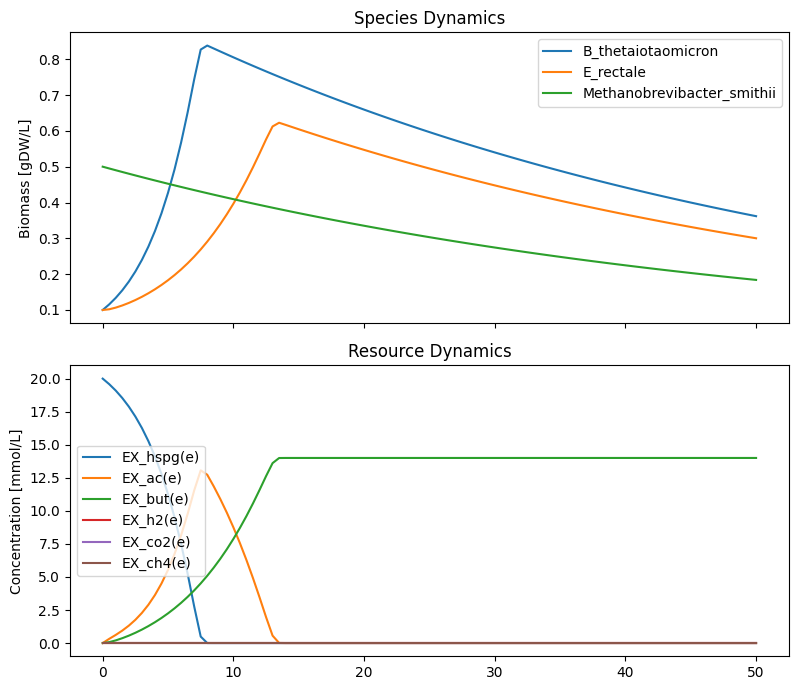

In [62]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)